This notebook provides a simple example of applying the re-normalization to a pruned model after the unstructured global magnitude pruning.

In [1]:
import sys
sys.path.append("..")

In [11]:
import torch
import torch.nn as nn
from source.utils.utils import load_model
from source.utils.data_funcs import load_data
from source.utils.logger import Logger
from source.utils.connect import make_tracked_net, make_repaired_net, reset_bn_stats, TrackLayer, ResetLayer
from source.utils.train import validate
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

import torch.nn.utils.prune as prune

In [3]:
class config:
    model = 'cifar_vgg16_ln'
    dataset = 'cifar10'
    special_init = 'vgg_init' # 'vgg_init' (kaiming init) or None (uniform init)
    print_freq = 100
    data_dir = '../../Linear_Mode_Connectivity/data'
    n = 3 # number of interpolation points

In [4]:
# necessary to create logger if using the train/validate/eval_line etc. functions
Logger.setup_logging()
logger = Logger()

trainset, testset = load_data(config.data_dir, config.dataset)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

trainset_noaug, _ = load_data(config.data_dir, config.dataset, no_random_aug=True)
trainloader_noaug = DataLoader(trainset_noaug, batch_size=128, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
sd = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/vgg_init/seed_10_step_lr/model_1_160.pt')
model = load_model(config).to(device)
model.load_state_dict(sd)

<All keys matched successfully>

In [ ]:
model_tracked = make_tracked_net(model, device)
reset_bn_stats(model_tracked, device, trainloader)

pruned_test = [[], []]
repair_test = [[], []]
sparsity_s = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
for amount in sparsity_s:
    model_global_pruned = deepcopy(model)

    conv_idx = []
    for i in range(len(model_global_pruned.features)):
        if isinstance(model_global_pruned.features[i], nn.Conv2d):
            conv_idx.append(i)
    parameters_pruned = []
    for i in conv_idx:
        parameters_pruned.append((getattr(model_global_pruned, f'features')[i], 'weight'))
    parameters_pruned.append((model_global_pruned.classifier[0], 'weight'))
    parameters_pruned = tuple(parameters_pruned)
    prune.global_unstructured(parameters_pruned, pruning_method=prune.L1Unstructured, amount=amount)

    for param, name in parameters_pruned:
        prune.remove(param, name)

    loss, acc, _, _ = validate(testloader, model_global_pruned, criterion, device, config)
    pruned_test[0].append(loss)
    pruned_test[1].append(acc)

    model_repaird = make_repaired_net(model_global_pruned, device)

    for track, reset in zip(model_tracked.modules(),
                            model_repaird.modules()):
        if not isinstance(track, TrackLayer):
            continue
        assert (isinstance(track, TrackLayer)
                and isinstance(reset, ResetLayer))

        # get neuronal statistics of original networks
        mu, std = track.get_stats()
        # set the goal neuronal statistics for the merged network
        mu = mu.clone()
        std = std.clone()
        goal_mean = mu
        goal_std = std
        reset.set_stats(goal_mean, goal_std)

    reset_bn_stats(model_repaird, device, trainloader)
    loss, acc, _, _ = validate(testloader, model_repaird, criterion, device, config)
    repair_test[0].append(loss)
    repair_test[1].append(acc)

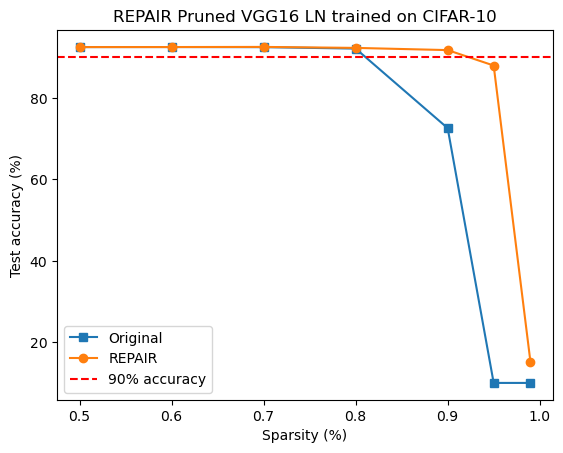

In [15]:
plt.plot(sparsity_s, pruned_test[1], label='Original', marker='s')
plt.plot(sparsity_s, repair_test[1], label='REPAIR', marker='o')
plt.axhline(y=90, color='r', linestyle='--', label='90% accuracy')
plt.xlabel('Sparsity (%)')
plt.ylabel('Test accuracy (%)')
plt.title('REPAIR Pruned VGG16 LN trained on CIFAR-10')
plt.legend()